# Distributions

*Purpose*: We will use distributions to model uncertain quantities. Distributions (and densities, random variables) are useful mathematical objects, but we will need to understand their properties to use them as effective models. This exercise is about distributions and their fundamental properties: In a future exercise (`e-grama06-fit-univar`) we will discuss how to model real quantities with distributions.


## Setup


In [1]:
import grama as gr
import numpy as np
DF = gr.Intention()
%matplotlib inline

# Motivation: Modeling Uncertainty

Before we discuss distributions, let's first talk about *why* distributions are necessary and useful.

## To Model Variability

Many real physical quantities exhibit *variability*; that is, different instances of "the same" quantity take different numerical values. This includes things like part geometry (tolerances), a person's height and weight, and even material properties. Let's look at a specific dataset of die cast aluminum material properties.


In [2]:
# NOTE: No need to edit
from grama.data import df_shewhart


If we inspect the `tensile_strength` values, we can see that they are quite variable.


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


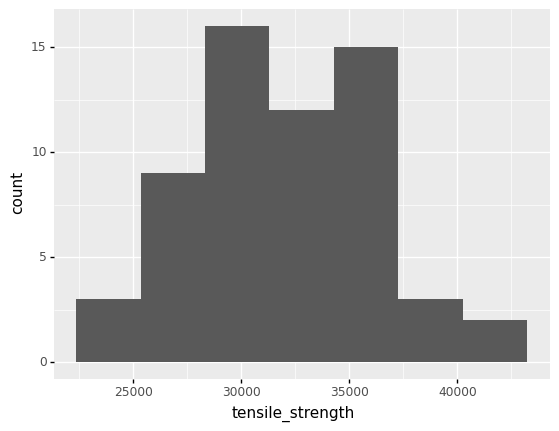

<ggplot: (8779106334148)>

In [3]:
# NOTE: No need to edit
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram()
)

In order to design in the presence of this variability, we need a way to represent this variability in a quantitative fashion. Distributions offer one way to quantitatively describe variability.


## To Summarize Data

A distribution is one way to *summarize* a dataset. Rather than using a (potentially large) dataset to describe a variable quantity, we can use a distribution.

Fitting a lognormal distribution allows us to summarize the variability in `tensile_strength`. The following code fits a lognormal distribution to the `tensile_strength` data.


In [4]:
# NOTE: No need to edit
# Fit a lognormal distribution
mg_tensile_strength = gr.marg_fit(
    "lognorm",
    df_shewhart.tensile_strength,
    floc=0,
)
# Show a summary
mg_tensile_strength

(+0) lognorm, {'mean': '3.187e+04', 's.d.': '4.019e+03', 'COV': 0.13, 'skew.': 0.38, 'kurt.': 3.26}

The distribution is defined in terms of a handful of *parameters*---scalar values that affect the quantitative properties of the distribution.

When we compare the fitted distribution against the data, we can see that the fitted distribution is in the same location and has the same width as the data.


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


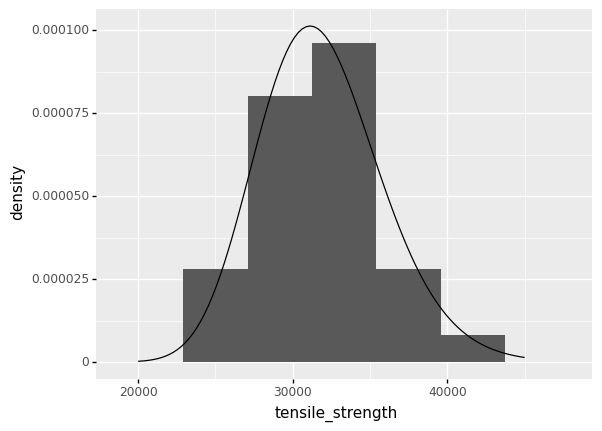

<ggplot: (8779123879403)>

In [5]:
# NOTE: No need to edit
# Visualize the density against the data
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(gr.aes(y=gr.after_stat("density")))
    + gr.geom_line(
        data=gr.df_make(tensile_strength=gr.linspace(20e3, 45e3, 100))
        >> gr.tf_mutate(d=mg_tensile_strength.d(DF.tensile_strength)),
        mapping=gr.aes(y="d")
    )
)

## To Make Assumptions Explicit

Selecting a distribtion helps us make assumptions about an uncertain quantity explicit. For instance, are we assuming that values are strictly bounded between low and high values? Or are there no bounds? 

For example, a normal distribution can take all values between $-\infty$ and $+\infty$, while a beta distribution has a finite width. The following visual compares the two distribution shapes.


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


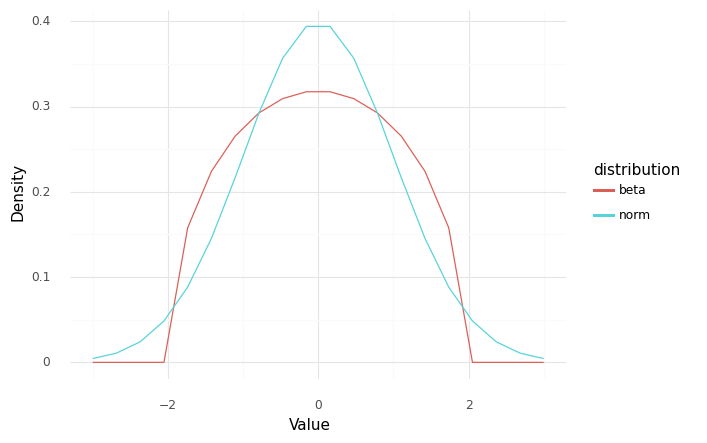

<ggplot: (8779145038065)>

In [6]:
# NOTE: No need to edit
# Normal is unbounded
mg_norm = gr.marg_mom("norm", mean=0, sd=1)
# Beta is strictly bounded
mg_beta = gr.marg_mom("beta", mean=0, sd=1, skew=0, kurt=2)

(
    gr.df_make(x=gr.linspace(-3, +3, 20))
    >> gr.tf_mutate(
        d_norm=mg_norm.d(DF.x),
        d_beta=mg_beta.d(DF.x),
    )
    >> gr.tf_pivot_longer(
        columns=["d_norm", "d_beta"],
        names_to=[".value", "distribution"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("x", "d", color="distribution"))
    + gr.geom_line()
    + gr.theme_minimal()
    + gr.labs(
        x="Value",
        y="Density",
    )
)

# Distribution Fundamentals

*Note*: In this exercise, to keep things simple, we will focus on distributions for *continuous* variable.


## What a distribution represents

*Fundamentally*, a distribution describes an uncertain value *in a quantitative fashion*. Rather than simply saying "I don't know what value this is," with a distribution we can express the fact that some values are more *likely* than others.

Distributions are particularly useful because they free us from "just" picking a single number. With a distribution we can get a lot more nuanced in our description of uncertain quantities. This exercise is all about using concepts about distributions to represent uncertain quantities.


## Random variables

Clearly `tensile_strength` does not take a single value; therefore, we should think of `tensile_strength` as a *random variable*. A random variable is a mathematical object that we can use to model an uncertain quantity. Unlike a *deterministic variable* that has one fixed value (say $x = 1$), a random variable can take a different value each time we *observe* it. For instance, if $X$ were a random variable, and we used $X_i$ to denote the value that occurs on the $i$-th observation, then we might see a sequence like

$$X_1 = 1, X_2 = -3, X_3 = 1, X_4 = 5, \dots$$

What counts as an *observation* depends on what we are using the random variable to model. Essentially, an observation is an occurrence that gives us the potential to "see" a new value. 

Let's take a look at the `tensile_strength` example to get a better sense of these ideas.


For the `tensile_strength`, we saw a sequence of different values:

In [7]:
# NOTE: No need to edit
(
    df_shewhart
    >> gr.tf_head(4)
)

,specimen,tensile_strength,hardness,density
0,1,29314,53.0,2.666
1,2,34860,70.2,2.708
2,3,36818,84.3,2.865
3,4,30120,55.3,2.627


Every time we manufacture a new part, we perform a sequence of manufacturing steps that work together to "lock in" a particular value of `tensile_strength`. Those individual steps tend to go slightly differently each time we make a part (e.g. an operator calls in sick one day, we get a slightly more dense batch of raw material, it's a particularly hot summer day, etc.), so we end up with different properties in each part.

Given the complicated realities of manfacturing, it makes sense to think of an *observation* as being one complete run of the manufacturing process that generates a particular part with its own `tensile_strength`. This is what the `specimen` column in `df_shewhart` refers to; a unique identifier tracking individual runs of the complete manufacturing process, resulting in a unique part.


```{admonition} Nomenclature: A *realization* is like a single roll of a die
Some nomenclature: When we talk about random quantities, we use the term *realization* (or *observation*) to refer to a single event that yields a random value, according to a particular distribution. For instance, a single manufactured part will have a realized strength value. If we take multiple realizations, we will tend to see different values. For instance, we saw a large amount of variability among the realized `tensile_strength` values above.

A single realization tells us very little about how the distribution tends to behave, but a set of realizations (a *sample*) will give us a sense of how the random values tend to behave *collectively*. A distribution is a way to model that collective behavior.
```

**A distribution defines a random variable**. We say that a random variable $X$ is *distributed according to* a particular distribution $\rho$, and we express the same statement mathematically as

$$X \sim \rho.$$

One way to represent a distribution is with a *density function*. The following plot displays the density for a normal distribution:


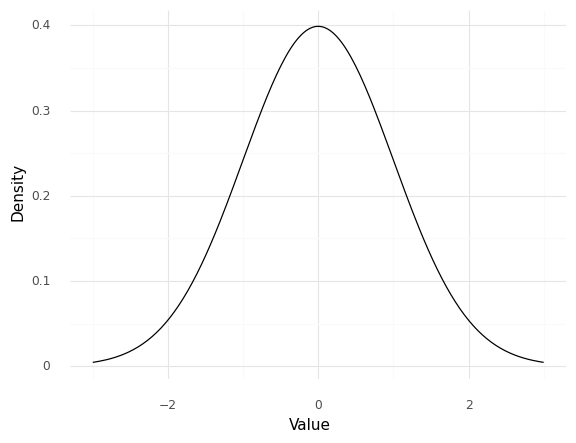

<ggplot: (8779106618103)>

In [8]:
## NOTE: No need to edit
# This visualizes a density function
(
    gr.df_make(x=gr.linspace(-3, +3, 200))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
    
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.theme_minimal()
    + gr.labs(
        x="Value",
        y="Density",
    )
)


The `Value` pictured here corresponds to all of the potential values that the random variable can take, while the `Density` quantitatively describes how likely (or unlikely) each of those values are. A value with a higher density will tend to occur more often. Density functions tend to "fall off" towards zero as we move towards more extreme values; these lower regions of the density are called "tails" of the distribution. The smallest values are associated with the "lower" or "left" tail, while the largest values are associated with the "upper" or "right" tail.


### __q1__ Define a distribution

Use the grama helper function `gr.marg_mom()` to define a distribution in terms of its *moments*. Fit a normal `"norm"` distribution with a mean of `1` and a standard deviation of `0.3`.


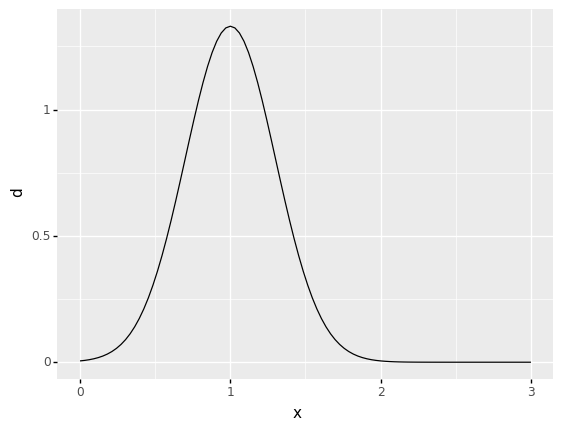

<ggplot: (8779106627301)>

In [9]:
## TASK: Define a normal distribution

mg_norm = gr.marg_mom("norm", mean=1, sd=0.3)
## NOTE: No need to edit; this will plot your distribution
(
    gr.df_make(x=gr.linspace(0, 3, 100))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
)

### __q2__ Check your distribution's summary

Print the distribution's summary by simply "executing" the distribution (like you would with a DataFrame or grama model).


In [10]:
## TASK: Print the summary of mg_norm
mg_norm
# solution-end

(+0) norm, {'mean': '1.000e+00', 's.d.': '3.000e-01', 'COV': 0.3, 'skew.': 0.0, 'kurt.': 3.0}

*Observations*

- What mean does your distribution have?
  - `mean = 1.0`
- What value of *skewness* does your distribution have?
  - `skewness = 0.0`
- What value of *kurtosis* does your distribution have?
  - `kurtosis = 3.0`
<!-- solution-end -->

## Moments

The summary of a distribution reports a few of its *moments*. These moments tell us different "facts" about the distribution:

| Moment | Meaning |
|--------|---------|
| Mean   | Location |
| Standard deviation | Width |
| Skewness | Left- or right-lopsidedness |
| Kurtosis | Tendency to produce extreme (large) values |

Note that the distribution summary also reports the *coefficient of variation* (COV), which is a normalized version of the standard deviation (`COV = sd / mean`).

The next few exercises will help you recognize how different moment values affect a distribution.


### __q3__ Compare different means

Inspect the following distribution summaries and the plot. Answer the questions under *obervations* below.


(+0) norm, {'mean': '-1.000e+00', 's.d.': '5.000e-01', 'COV': -0.5, 'skew.': 0.0, 'kurt.': 3.0}
(+0) norm, {'mean': '1.000e+00', 's.d.': '5.000e-01', 'COV': 0.5, 'skew.': 0.0, 'kurt.': 3.0}


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


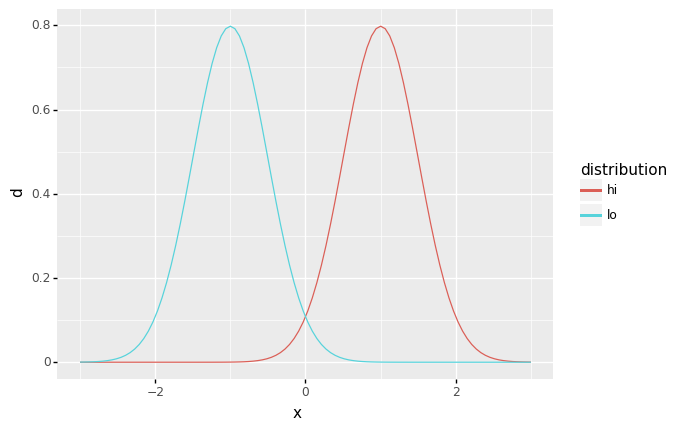

<ggplot: (8779145236625)>

In [11]:
## NOTE: No need to edit; this will plot and compare two distributions
mg_lo = gr.marg_mom("norm", mean=-1, sd=0.5)
mg_hi = gr.marg_mom("norm", mean=+1, sd=0.5)

## Print the summaries
print(mg_lo)
print(mg_hi)

## Visualize the distributions
(
    gr.df_make(x=gr.linspace(-3, 3, 100))
    >> gr.tf_mutate(
        d_lo=mg_lo.d(DF.x),
        d_hi=mg_hi.d(DF.x),
    )
    >> gr.tf_pivot_longer(
        columns=["d_lo", "d_hi"],
        names_to=[".value", "distribution"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("x", "d", color="distribution"))
    + gr.geom_line()
)

*Observations*

- What is the mean (`mean`) of the `lo` distribution? How does that compare with the `mean` of the `hi` distribution?
  - For `lo`: `mean == -1`, for `hi`: `mean == +1`.
- The mean is a measure of the "location" of a distribution: In your own words, how does the `lo` distribution compare with the `hi` distribution?
  - The `lo` distribution is shifted to the left (towards more negative values) than the `hi` distribution. Both are identical in shape; they are simply located at different centers.
<!-- solution-end -->

### __q4__ Compare different standard deviations

Inspect the following distribution summaries and the plot. Answer the questions under *obervations* below.


/Users/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars
/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(+0) norm, {'mean': '0.000e+00', 's.d.': '5.000e-01', 'COV': inf, 'skew.': 0.0, 'kurt.': 3.0}
(+0) norm, {'mean': '0.000e+00', 's.d.': '1.000e+00', 'COV': inf, 'skew.': 0.0, 'kurt.': 3.0}


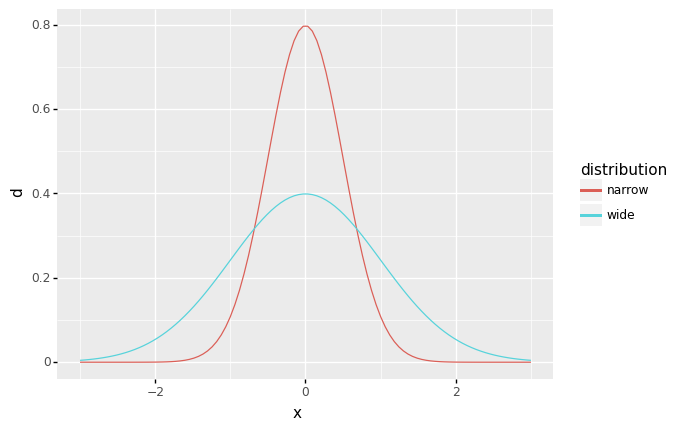

<ggplot: (8779124034265)>

In [12]:
## NOTE: No need to edit; this will plot and compare distributions
mg_narrow = gr.marg_mom("norm", mean=0, sd=0.5)
mg_wide = gr.marg_mom("norm", mean=0, sd=1.0)

## Print the summaries
print(mg_narrow)
print(mg_wide)

## Visualize the distributions
(
    gr.df_make(x=gr.linspace(-3, 3, 100))
    >> gr.tf_mutate(
        d_narrow=mg_narrow.d(DF.x),
        d_wide=mg_wide.d(DF.x),
    )
    >> gr.tf_pivot_longer(
        columns=["d_narrow", "d_wide"],
        names_to=[".value", "distribution"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("x", "d", color="distribution"))
    + gr.geom_line()
)

*Observations*

- What is the standard deviation (`sd`) of the `narrow` distribution? How does that compare with the `sd` of the `wide` distribution?
  - The `narrow` distribution has `sd == 0.5`, the `wide` distribution has `sd == 1.0`.
- Standard deviation is a measure of "width" of a distribution: In your own words, how does the `wide` distribution compare with the `narrow` distribution?
  - For the `wide` distribution, larger values (more-negative and more-positive) are more plausible (as measured by a larger density).
<!-- solution-end -->

### __q5__ Compare different skewnesses

Inspect the following distribution summaries and the plot. Answer the questions under *obervations* below.


(+0) norm, {'mean': '1.000e+00', 's.d.': '3.000e-01', 'COV': 0.3, 'skew.': 0.0, 'kurt.': 3.0}
(+0) lognorm, {'mean': '1.000e+00', 's.d.': '5.000e-01', 'COV': 0.5, 'skew.': 1.62, 'kurt.': 8.04}


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


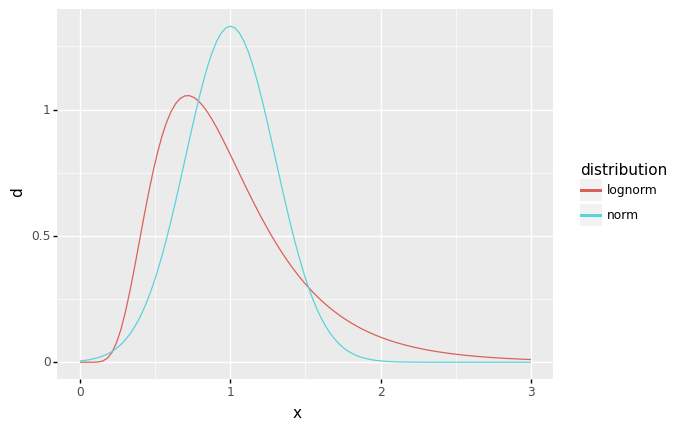

<ggplot: (8779124051023)>

In [13]:
## NOTE: No need to edit; this will plot and compare distributions
mg_lognorm = gr.marg_mom("lognorm", mean=1, sd=0.5, floc=0)

## Print the summaries
print(mg_norm)
print(mg_lognorm)

## Visualize the distributions
(
    gr.df_make(x=gr.linspace(0, 3, 100))
    >> gr.tf_mutate(
        d_norm=mg_norm.d(DF.x),
        d_lognorm=mg_lognorm.d(DF.x),
    )
    >> gr.tf_pivot_longer(
        columns=["d_norm", "d_lognorm"],
        names_to=[".value", "distribution"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("x", "d", color="distribution"))
    + gr.geom_line()
)

*Observations*

- What is the `skew.` of the `norm` distribution? How does that compare with the `skew` of the `lognorm` distribution?
  - The `norm` distribution has `skew. == 0`, while the `lognorm` distribution has `skew. == 1.62`.
- Skewness is related to asymmetry of a distribution: In your own words, how is the lognormal distribution above asymmetric?
  - The lognormal distribution has a "longer" right tail
<!-- solution-end -->

## Simulating values

With a distribution, we can draw realizations in to generate a synthetic dataset. 


### __q6__ *Draw* random values from your distribution

Use the `Marginal.r(n)` method to *draw* `1000` random values from your distribution. Play with the sample size `n`, and answer the questions under *observations* below.

*Hint*: A *method* is a function that you invoke using dot notation. If the marginal were named `mg`, then you could call the random value method via `mg.r(1000)`.


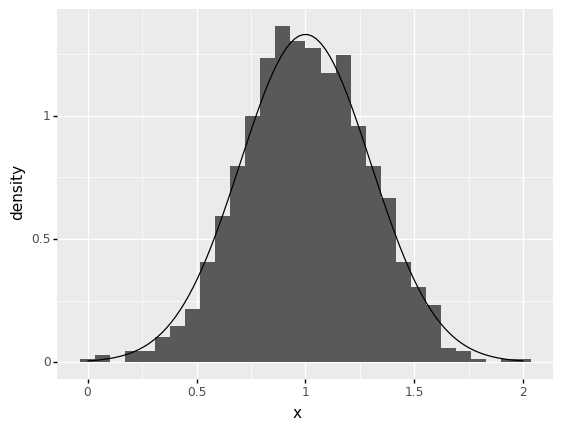

<ggplot: (8779124024191)>

In [14]:
## TASK: Draw 1000 random values from mg_norm

X = mg_norm.r(1000)
## NOTE: No need to edit; use this to check your answer
(
    gr.df_make(x=X)
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_histogram(bins=30, mapping=gr.aes(y="stat(density)"))
    + gr.geom_line(
        data=gr.df_make(x=gr.linspace(0, 2, 100))
        >> gr.tf_mutate(d=mg_norm.d(DF.x)),
        mapping=gr.aes(y="d")
    )
)

*Observations*



## Estimating the Mean

The average of multiple realizations $X_i \sim \rho$ is called the *sample mean*

$$\overline{X} = \frac{1}{n} \sum_{i=1}^n X_i.$$

The true mean of a distribution is called the *expectation* $\mathbb{E}[X]$. The sample mean will tend to converge to the true mean as the number of realizations $n$ increases

$$\lim_{n\to\infty} \frac{1}{n} \sum_{i=1}^n X_i = \mathbb{E}[X].$$

However, when $n < \infty$, the sample mean will tend to be different from the true mean of the distribution.

### __q7__ Estimate a (sample) mean

Complete the following code to compute the sample mean. Answer the questions under *observations* below.


In [15]:
## TASK: Compute the sample mean
# NOTE: No need to edit; this will report the true mean
print(mg_norm)

(
    gr.df_make(x=mg_norm.r(100))

    >> gr.tf_summarize(
        x_mean=gr.mean(DF.x)
    )
)

(+0) norm, {'mean': '1.000e+00', 's.d.': '3.000e-01', 'COV': 0.3, 'skew.': 0.0, 'kurt.': 3.0}


,x_mean
0,0.98557


*Observations*

- How does the sample mean compare with the true mean of your distribution `mg_norm`?
  - The value is different each time, but I get a value quite close to `1.0`, the true mean.
- What might account for this difference?
  - We took a limited sample $n < \infty$, thus there is sampling error in the estimated mean.
- Re-run the cell; do you get an identical value?
  - Nope! There is randomness in the estimate.
<!-- solution-end -->

```{admonition} The sample mean is a random variable
Noting that the sample mean will tend to be different from the true mean highlights the essence of estimation with limited data: The sample mean is itself a random quantity.

Note that the sample mean (and other estimated quantities) tend to exhibit *erroneous variability*; there is some true fixed value for the mean, and we see variability only because we have collected a limited amount of data. Increasing our sample size will tend to reduce this variability. Since this uncertainty is due to sampling, it is also called *sampling uncertainty*.
```

## Probability

Probability is the area under the density curve, within a set that you specify. Thus probability is associated with both a set $A$ and a random variable $X$. The set $A$ is chosen to correspond to an *event* of interest.

For instance, if we were interested in the probability of the event $A = \{0.5 <= X <= 0.7\}$, the following area would be the probability:


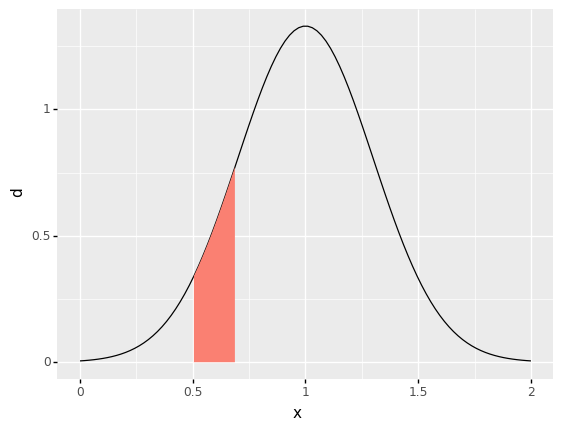

<ggplot: (8779145316340)>

In [16]:
## NOTE: No need to edit; run and inspect
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 100))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_ribbon(
        data=df_tmp
        >> gr.tf_filter(0.5 <= DF.x, DF.x <= 0.7),
        mapping=gr.aes(ymin=0, ymax="d"),
        fill="salmon",
        color=None,
    )
)

Note that probability is associated with a *set*---a range of values---not just a single value. Note that the area under the curve for a single value would have zero width, hence zero probability! 

The following pictures the case where $\{X = 1\}$, an event with just one value.


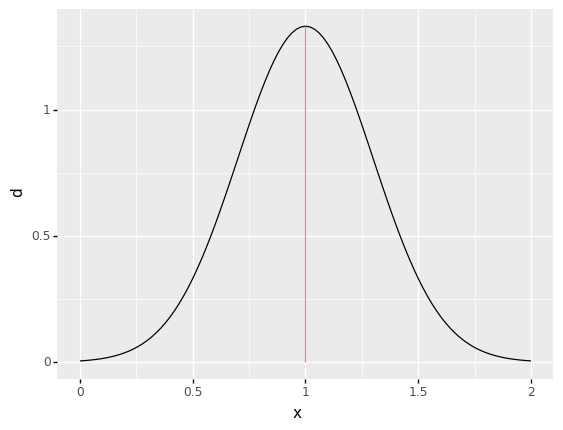

<ggplot: (8779124021221)>

In [17]:
## NOTE: No need to edit; run and inspect
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 101))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_segment(
        data=df_tmp
        >> gr.tf_filter(DF.x == gr.median(DF.x)),
        mapping=gr.aes(xend="x", yend=0),
        color="salmon",
    )
)

A more mathematical definition for probability is in terms of the expectation

$$\mathbb{P}[X \in A] = \mathbb{E}[1(X \in A)]$$

where $1(X \in A)$ is the *indicator function*, which is just a compact way of tracking whether or not a point lands in the set $A$. The function takes values $1,0$ depending on whether or not a value $X$ lands inside the set $A$.

$$1(X \in A) = \left\{\begin{array}{cc} 1 & \text{ if }X \in A \\ 0 & \text{ otherwise}\end{array}\right.$$

This expectation definition is not just math for its own sake; this expectation of the indicator definition is **easy to translate into computer code**. We can use the sample mean of an indicator to estimate a probability

$$\mathbb{P}[X \in A] \approx \frac{1}{n} \sum_{i=1}^n 1(X_i \in A).$$

You will use this expression in the next tasks to approximate a probability.


### __q8__ Compute an indicator

Compute an indicator for the event $A = \{X \leq +1\}$.

*Hint*: Comparison operators like `<`, `>`, `<=`, `>=`, and `==` return boolean values `True` and `False`. However, python also treats these as numerical values, where `True == 1` and `False == 0`. This means you can use a simple comparison to compute an indicator value!


In [18]:
## TASK: Compute an indicator for the event where x <= 1
df_ind = (
    gr.df_make(x=mg_norm.r(100))
    >> gr.tf_mutate(

        ind=DF.x <= 1,
    )
)

# NOTE: No need to edit; use this to check your work
assert \
    "ind" in df_ind.columns, \
    "The result df_ind does not have an indicator column `ind`"

assert \
    (all(df_ind.ind == (df_ind.x <= 1))), \
    "Your indicator column `ind` is incorrect."

df_ind

,x,ind
0,1.110060,False
1,0.637335,True
2,1.473643,False
3,0.854875,True
4,1.531506,False
...,...,...
95,0.633529,True
96,1.215205,False
97,0.717967,True
98,0.548411,True


### __q9__ Estimate a probability

Use the definition of probability along with your indicator value to approximate the probability that $X \leq 1$.


In [19]:
## TASK: Estimate the probability; call that column `pr`
df_pr = (
    df_ind

    >> gr.tf_summarize(pr=gr.mean(DF.ind))
)

# NOTE: No need to edit; use this to check your work
assert \
    "pr" in df_pr.columns, \
    "The result df_pr does not have the column `pr`"

assert \
    df_pr.pr.values[0] == df_ind.ind.mean(), \
    "The value of df_pr.pr is incorrect"

df_pr

,pr
0,0.51


## Probability of Failure

Probability is useful as a quantitative measure of a design's performance. For example, reliability engineers strive to produce designs that have a low *probability of failure*. This is important for safety-critical applications, such as in the design of buildings, bridges, or aircraft.

To use probability to describe failure, we need to define an event $A$ that corresponds to failure for the system we are studying. For example, with the `tensile_strength` of an alloy, we can say failure occurs when the applied stress is greater than the strength. Rendered mathematically, this is the event

$$A_{\text{failure}} = \{\sigma_{\text{strength}} \leq \sigma_{\text{applied}}\}.$$

The probability of failure is then

$$\text{POF} = \mathbb{P}[A_{\text{failure}}].$$

We can approximate the probability of failure of a part if we know the applied stress and have a dataset of `tensile_strength` values.


### __q10__ Estimate a probability of failure

Suppose the applied stress is $\sigma_{\text{applied}} = 25 \times 10^3$ psi. Estimate the probability of failure of a part following the distribution of `tensile_strength` in the `df_shewhart` dataset. Answer the questions under *observations* below.


In [20]:
## TASK: Estimate the probability of failure associated with the applied stress above
## provide this as the column `pof`
df_pof = (
    df_shewhart

    >> gr.tf_summarize(
        pof=gr.mean(DF.tensile_strength <= 25e3)
    )
)

# NOTE: No need to edit; use this to check your work
assert \
    "pof" in df_pof.columns, \
    "The result df_pof does not have the column `pof`"

assert \
    abs(df_pof.pof.values[0] - 0.05) < 1e-3, \
    "The value of df_pof.pof is incorrect"

df_pof


,pof
0,0.05


*Observations*

- What probability of failure `pof` did you estimate?
  - I estimate `pof == 0.05`
- Is your value `pof` the *true* probability of failure? Why or why not?
  - No; remember that any time we have a limited dataset there is sampling uncertainty. Like the sample mean we computed above, the estimated pof here is not exactly equal to the true pof.
<!-- solution-end -->

## Quantiles

Quantiles "turn around" the idea of probability. With probability we start with a set $A$ and arrive at a probability value $p$. With a *quantile* we start with a probability value $p$ and arrive at a set $A$ that is below a single value $q$; that is $A = \{X \leq q\}$.

For instance, for a normal distribution the `0.50` quantile is the value $q$ where 50% of the probability lies below that value; this will be the middle of the distribution, which happens to be the mean:


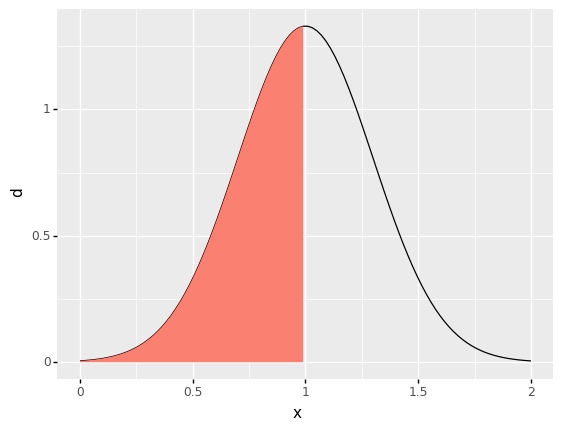

<ggplot: (8779145316346)>

In [21]:
## NOTE: No need to edit; run and inspect
# Compute the 0.50 quantile
q_mid = mg_norm.q(0.50)

# Visualize
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 100))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_ribbon(
        data=df_tmp
        >> gr.tf_filter(0.0 <= DF.x, DF.x <= q_mid),
        mapping=gr.aes(ymin=0, ymax="d"),
        fill="salmon",
        color=None,
    )
)

However, quantiles allow us to target values other than the mean. For instance, we could seek a moderately low value by targeting the `0.25` quantile, which will be the point where 25% of the probability is below the value $q$.


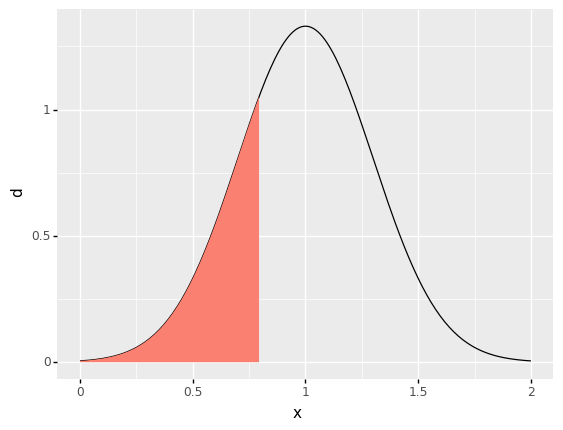

<ggplot: (8779145337697)>

In [22]:
## NOTE: No need to edit; run and inspect
# Compute the 0.25 quantile
q_lo = mg_norm.q(0.25)

# Visualize
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 200))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_ribbon(
        data=df_tmp
        >> gr.tf_filter(0.0 <= DF.x, DF.x <= q_lo),
        mapping=gr.aes(ymin=0, ymax="d"),
        fill="salmon",
        color=None,
    )
)

As with the sample mean and a sample probability, we can compute sample quantiles from a dataset.

### __q11__ Compute sample quantiles

Use the quantile method `q()` to compute the `0.10` and `0.50` quantiles of the `mg_norm` distribution. Answer the questions under *observations* below.


In [23]:
## TASK: Compute the exact 0.10 and 0.50 quantiles of mg_norm

q_10 = mg_norm.q(0.10)
q_50 = mg_norm.q(0.50)
## NOTE: No need to edit; use this to check your work
# This compute sample quantiles
(
    gr.df_make(x=mg_norm.r(1000))
    >> gr.tf_summarize(
        pr_10=gr.mean(DF.x <= q_10), # Should be around 0.10
        pr_50=gr.mean(DF.x <= q_50), # Should be around 0.50
    )
)

,pr_10,pr_50
0,0.116,0.537


*Observations*

- Are the `q_10` and `q_50` you computed above *sample* values or *true* values of `mg_norm`?
  - `q_10` and `q_50` are the *true* quantiles of `mg_norm`.
- What does the line of code `pr_10=gr.mean(DF.x <= q_10)` compute?
  - This compute the probability that `x` is below the value `q_10`
- Why are the values `pr_10` and `pr_50` not *exactly* equal to the probability values used to compute `q_10` and `q_50`?
  - `pr_10` and `pr_50` are sample probabilities, not true probabilities. Since there is sampling uncertainty, their values will be close to---but not exactly equal to---their true value.
<!-- solution-end -->

## Conservative values

Quantiles are a useful way to define *conservative* values associated with a desired probability. Rather than simply "take the mean" of a set of values, we can pick a small or larger probability and compute an associated quantile.

For instance, since failure under tensile loading occurs when $\sigma_{\text{strength}} \leq \sigma_{\text{applied}}$, taking a lower quantile of `tensile_strength` will provide a conservative value appropriate for design.


### __q12__ Estimate a conservative strength

Compute the empirical `0.10` quantile of the `tensile_strength` in `df_shewhart`; provide this as the column `lower`. Additionally, compute the sample mean of `tensile_strength`; provide this as the column `mean`. Answer the questions under *observations* below.


In [24]:
## TASK: Compute the lower 0.10 quantile and mean of `tensile_strength`
df_values = (
    df_shewhart 

    >> gr.tf_summarize(
        lower=gr.quant(DF.tensile_strength, 0.10),
        mean=gr.mean(DF.tensile_strength),
    )
)

# NOTE: No need to edit; use this to check your work
assert \
    "lower" in df_values.columns, \
    "The result df_values does not have the column `lower`"

assert \
    "mean" in df_values.columns, \
    "The result df_values does not have the column `mean`"

assert \
    df_values.lower.values[0] == gr.quant(df_shewhart.tensile_strength, 0.10), \
    "incorrect value of `lower`"

print(df_values)
print("")
print(
    df_shewhart
    >> gr.tf_summarize(
        pof_lower=gr.mean(DF.tensile_strength <= df_values.lower.values[0]),
        pof_mean=gr.mean(DF.tensile_strength <= df_values['mean'].values[0]),
    )
)

     lower          mean
0  26395.0  31869.366667

   pof_lower  pof_mean
0        0.1       0.5


*Observations*

- Are the `lower` and `mean` values that you computed *sample* values or *true* values?
  - These are both *sample* values, as they are computed from a dataset.
- What probability of failure `pof` is associated with the `lower` value? What probability of failure `pof` is associated with the `mean`?
  - The `lower` value is associated with `pof == 0.1`; the `mean` value is associated with `pof == 0.5`.
- Suppose the observed variability in the `tensile_strength` is real. Which of `mean` or `lower` is safer to use for design purposes? Why?
  - If the variability is real, then `lower` is definitely safer for design. Real variability means that parts can end up with a strength lower than the `mean`; thus if we design assuming the `mean` value, real parts may end up failing.
